In [1]:
import logging

import numpy as np
import probtorch
import torch

import dynamical_ball
import bouncing_ball_data
import combinators
import foldable
import importance
import mcmc
import utils

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [5]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [6]:
num_particles = (100,)

In [7]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [8]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [9]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [10]:
def accumulate_trajectory(inference):
    result = torch.zeros(*num_particles, len(trajectory), 2)
    result[:, 0] = inference['Reduce/Foldable(0)/InitBallDynamics']['position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['Reduce/Foldable(%d)/StepBallDynamics' % t]['velocity_%d' % t].value
    return result

In [11]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [12]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [13]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [14]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [15]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [16]:
def proposal_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Foldable(step_proposal, initializer=init_proposal),
                           lambda: range(T))

In [17]:
def training_initializer():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    return combinators.GuidedConditioning(init_bouncing_ball, init_proposal)

In [18]:
def training_step():
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return combinators.GuidedConditioning(bouncing_ball_step, step_proposal)

In [19]:
def training_model():
    return foldable.Reduce(foldable.Foldable(training_step(), initializer=training_initializer()), lambda: range(T))

02/19/2019 17:47:26 ELBO=-6.06093445e+02 at epoch 1
02/19/2019 17:47:27 ELBO=-5.76047791e+02 at epoch 2
02/19/2019 17:47:27 ELBO=-6.46150452e+02 at epoch 3
02/19/2019 17:47:28 ELBO=-5.17958923e+02 at epoch 4
02/19/2019 17:47:29 ELBO=-6.67506348e+02 at epoch 5
02/19/2019 17:47:29 ELBO=-6.11353271e+02 at epoch 6
02/19/2019 17:47:30 ELBO=-5.53527893e+02 at epoch 7
02/19/2019 17:47:31 ELBO=-6.36257080e+02 at epoch 8
02/19/2019 17:47:32 ELBO=-5.80938660e+02 at epoch 9
02/19/2019 17:47:32 ELBO=-5.78851929e+02 at epoch 10
02/19/2019 17:47:33 ELBO=-5.97240112e+02 at epoch 11
02/19/2019 17:47:34 ELBO=-5.83026123e+02 at epoch 12
02/19/2019 17:47:35 ELBO=-5.64312927e+02 at epoch 13
02/19/2019 17:47:35 ELBO=-5.65910522e+02 at epoch 14
02/19/2019 17:47:36 ELBO=-5.67126953e+02 at epoch 15
02/19/2019 17:47:37 ELBO=-5.59167480e+02 at epoch 16
02/19/2019 17:47:38 ELBO=-5.24662415e+02 at epoch 17
02/19/2019 17:47:38 ELBO=-5.18843994e+02 at epoch 18
02/19/2019 17:47:39 ELBO=-5.58744202e+02 at epoch 19
02

Epoch   343: reducing learning rate of group 0 to 5.0000e-02.


02/19/2019 17:51:45 ELBO=-2.58053009e+02 at epoch 345
02/19/2019 17:51:46 ELBO=-2.38062988e+02 at epoch 346
02/19/2019 17:51:47 ELBO=-2.48452225e+02 at epoch 347
02/19/2019 17:51:48 ELBO=-2.50182281e+02 at epoch 348
02/19/2019 17:51:49 ELBO=-2.53760529e+02 at epoch 349
02/19/2019 17:51:50 ELBO=-2.36874634e+02 at epoch 350
02/19/2019 17:51:50 ELBO=-2.45181854e+02 at epoch 351
02/19/2019 17:51:51 ELBO=-2.47942688e+02 at epoch 352
02/19/2019 17:51:52 ELBO=-2.46631622e+02 at epoch 353
02/19/2019 17:51:53 ELBO=-2.34705246e+02 at epoch 354
02/19/2019 17:51:54 ELBO=-2.40277161e+02 at epoch 355
02/19/2019 17:51:54 ELBO=-2.33548813e+02 at epoch 356
02/19/2019 17:51:55 ELBO=-2.42251587e+02 at epoch 357
02/19/2019 17:51:56 ELBO=-2.53815903e+02 at epoch 358
02/19/2019 17:51:57 ELBO=-2.81051147e+02 at epoch 359
02/19/2019 17:51:57 ELBO=-2.42000549e+02 at epoch 360
02/19/2019 17:51:58 ELBO=-2.39036179e+02 at epoch 361
02/19/2019 17:51:59 ELBO=-2.44511780e+02 at epoch 362
02/19/2019 17:52:00 ELBO=-2.

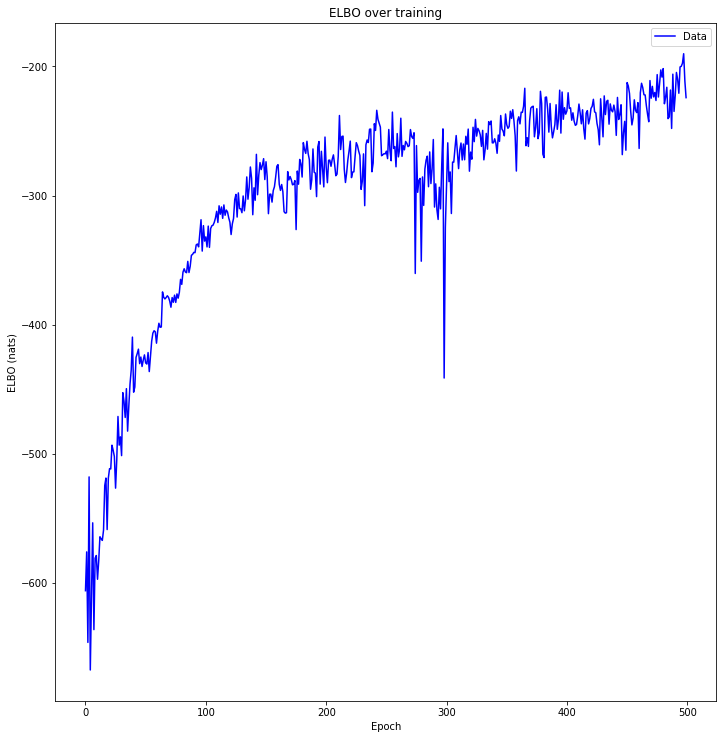

ValueError: too many values to unpack (expected 2)

In [20]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model()
    
    inference, trained_params, elbos = importance.variational_importance(
        importance_sampler, 500, data,
        use_cuda=False, lr=1e-1, inclusive_kl=False,
        patience=100,
    )
    utils.plot_evidence_bounds(elbos, True)
    
    bouncing_ball_posterior = mcmc.reduce_resample_move_smc(importance_sampler.folder.operator, lambda: range(T),
                                                            initializer=importance_sampler.folder._initializer, moves=5)
    (dynamics, position), inference, _ = bouncing_ball_posterior(data=data)
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Foldable(%d)/StepBallDynamics' % t]['velocity_%d' % t].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [ ]:
trained_params

In [ ]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])

In [ ]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

In [ ]:
bouncing_ball_smc = importance.reduce_smc(importance_sampler.folder.operator, lambda: range(T), initializer=importance_sampler.folder._initializer)
(dynamics, position), inference, _ = bouncing_ball_smc(data=data)
inferred_trajectory = accumulate_trajectory(inference)
positions = inferred_trajectory.mean(dim=0).cpu().detach()

In [ ]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

In [ ]:
graph_original_trajectory(trajectory, T, s)
graph_inferred_trajectory(positions, T, s)